In [1]:
# Import libraries
import numpy as np
import math
import random
import pandas as pd

import scipy.stats as stats
from statsmodels.stats.multitest import multipletests

import statsmodels.api as sm # linear regression

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

import scanpy as sc
from gprofiler import GProfiler

import os

# Directory path
myDir = "/Users/junjie/Desktop/OneDrive - The University of Chicago (1)/Python"
os.chdir(myDir)
import ProxseqClasses as PC
import calculateweightedPPI as WPPI
import ProxseqFunctions as PF

#*****
mpl.rcdefaults()
# Set font to be arial
mpl.rc('font', **{'sans-serif':'Arial', 'size':12})
mpl.rcParams['mathtext.rm'] = 'sans' # to have non-italic greek letter, use r'$\mathrm{\alpha}$', does NOT work with f-string
mpl.rcParams['axes.titlesize'] = 12
# Set default tick size
mpl.rcParams['xtick.major.size'] = 5.5
mpl.rcParams['ytick.major.size'] = 5.5
mpl.rcParams['xtick.minor.size'] = 2.5
mpl.rcParams['ytick.minor.size'] = 2.5
# Default legend settings
mpl.rcParams['legend.fancybox'] = False
mpl.rcParams['legend.edgecolor'] = 'k'

#to store text as text, not as path
new_rc_params = {'text.usetex': False,
                 "svg.fonttype": 'none'}
mpl.rcParams.update(new_rc_params)
#*****
# Seed number
np.random.seed(2025)
random.seed(2025)

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
save_dir = '/Users/junjie/Library/CloudStorage/OneDrive-TheUniversityofChicago(1)/Experimental data/Glycan_proxseq/manuscript/fig_update_v2/'

In [4]:
# Define the CLR normalization function adapted from Seurat
def clr_function(column):
    # Filter out zeros for log transformation and only include positive values
    positive_values = column[column > 0]
    
    # Calculate the mean of log-transformed positive values
    mean_log = np.sum(np.log1p(positive_values)) / len(column)
    
    # Normalize by subtracting the exponential mean from each log-transformed value
    clr_values = np.log1p(column / np.exp(mean_log))
    
    return clr_values

In [5]:
#read data
#raw count data
donor1_ctrl_data = pd.read_csv('GPS/20250521/ctrl_raw_lectin.csv',index_col=0)
donor2_lectin_data = pd.read_csv('GPS/20250221/pbmc_raw_lectin_df.csv', index_col=0)

In [6]:
#read annotation
donor1_annotation = pd.read_csv('GPS/20250521/ctrl_annotations_0801.csv', index_col=0)
donor2_annotation = pd.read_csv('GPS/20250521/donor2_annotation_20250602_latest.csv', index_col=0)

In [8]:
annotation_map = {
    "CD4+ Naive T cells": "CD4 T cells",
    "CD4+ Central Memory": "CD4 T cells",
    "CD4+ Effector Memory": "CD4 T cells",
    
    "CD8+ Naive T cells": "CD8 T cells",
    "CD8+ Central Memory": "CD8 T cells",
    "CD8+ Effector Memory": "CD8 T cells",
    "CD8+ Effector Memory RA": "CD8 T cells",

    "NK cells_CD56+CD16+": "NK cells",
    "NK cells_CD56+CD16-": "NK cells",
    "NK T cells": "NK T cells",
    
    "B cells": "B cells",
    "Dendritic Cells": "Dendritic cells",
    "Monocytes": "Monocytes",
    
    "Treg": "CD4 T cells",  # often grouped under CD4 lineage
    "Other": "Other"
}

# Apply mapping to create a new column
donor1_annotation["main_annotation"] = donor1_annotation["manual_annotation_reclustered"].map(annotation_map)

In [9]:
donor1_annotation.value_counts()

manual_annotation_reclustered  main_annotation
CD4+ Effector Memory           CD4 T cells        2705
CD4+ Naive T cells             CD4 T cells        1169
NK cells_CD56+CD16+            NK cells           1055
CD8+ Effector Memory RA        CD8 T cells        1032
CD4+ Central Memory            CD4 T cells         944
CD8+ Effector Memory           CD8 T cells         884
CD8+ Central Memory            CD8 T cells         660
CD8+ Naive T cells             CD8 T cells         484
NK cells_CD56+CD16-            NK cells            180
NK T cells                     NK T cells          120
Treg                           CD4 T cells         112
B cells                        B cells              47
Monocytes                      Monocytes            34
Dendritic Cells                Dendritic cells      24
Other                          Other                20
Name: count, dtype: int64

In [10]:
#filter cell indices
donor1_lectin = donor1_ctrl_data.loc[:,donor1_annotation.index].T
donor2_lectin = donor2_lectin_data.loc[:,donor2_annotation.index].T
#add annotation information
donor1_lectin['cell_type'] = donor1_annotation['main_annotation']
donor2_lectin['cell_type'] = donor2_annotation['main_annotation']

In [11]:
d1_lectin_grouped = donor1_lectin.groupby("cell_type").sum()
d2_lectin_grouped = donor2_lectin.groupby("cell_type").sum() 
#Normalize lectin binding to proportions within each group
d1_proportions = d1_lectin_grouped.div(d1_lectin_grouped.sum(axis=1), axis=0)
d2_proportions = d2_lectin_grouped.div(d2_lectin_grouped.sum(axis=1), axis=0)

In [12]:
main_cell_type = ['B cells','CD4 T cells', 'CD8 T cells',  'NK T cells', 'NK cells', 'Monocytes','Dendritic cells' ]

In [13]:
d1_lectin_order = ['ConA','PHA-L', 'PHA-E', 'DSL',  'MAL-I', 'MAL-II', 'SNA', 'LEL', 'GSL-II', 'Galectin-3',
                   'ECA', 'PNA','DBA', 'AAL', 'UEA-I' ]

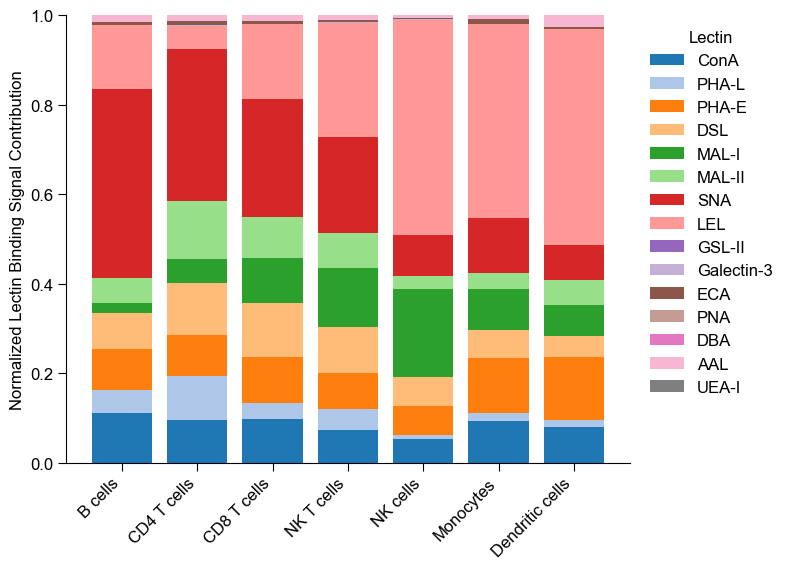

In [17]:
#lectin binding compositions of main cell type, donor1
# --- Reorder rows and columns ---
d1_plot_df = d1_proportions.loc[main_cell_type, d1_lectin_order]

# --- Bar positions ---
bar_positions = np.arange(len(main_cell_type))
stack_data = [d1_plot_df[lectin].values for lectin in d1_lectin_order]

# --- Plotting ---
fig, ax = plt.subplots(figsize=(len(main_cell_type) * 0.6 + 4, 6))
bottom = np.zeros(len(main_cell_type))
colors = plt.cm.tab20.colors  # 20 distinct colors

for i, (lectin, values) in enumerate(zip(d1_lectin_order, stack_data)):
    ax.bar(bar_positions, values, bottom=bottom, label=lectin, color=colors[i % len(colors)])
    bottom += values

# --- Formatting ---
ax.set_xticks(bar_positions)
ax.set_xticklabels(main_cell_type, rotation=45, ha='right')
ax.set_ylabel("Normalized Lectin Binding Signal Contribution")
ax.set_ylim(0, 1.0)
ax.legend(title="Lectin", bbox_to_anchor=(1.01, 1), loc='upper left', frameon=False)

fig.tight_layout(pad=1.5)
sns.despine()
fig.savefig(save_dir + 'donor1_ldt_cell_profile.svg', format = 'svg', bbox_inches='tight', pad_inches=0)

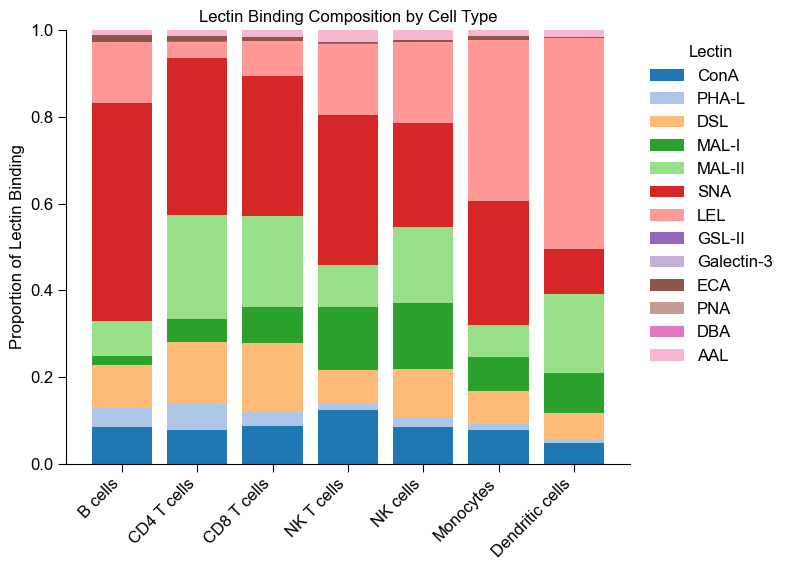

In [12]:
#donor2
d2_lectin_order = ['ConA','PHA-L', 'DSL',  'MAL-I', 'MAL-II', 'SNA', 'LEL', 'GSL-II', 'Galectin-3',
                   'ECA', 'PNA','DBA', 'AAL']

#lectin binding compositions of main cell type, donor1
# --- Reorder rows and columns ---
d2_plot_df = d2_proportions.loc[main_cell_type, d2_lectin_order]

# --- Bar positions ---
bar_positions = np.arange(len(main_cell_type))
stack_data = [d2_plot_df[lectin].values for lectin in d2_lectin_order]

# --- Plotting ---
fig, ax = plt.subplots(figsize=(len(main_cell_type) * 0.6 + 4, 6))
bottom = np.zeros(len(main_cell_type))
color_palette = sns.color_palette("tab20", n_colors=len(d1_lectin_order))
lectin_color_map = dict(zip(d1_lectin_order, color_palette))


for i, (lectin, values) in enumerate(zip(d2_lectin_order, stack_data)):
    ax.bar(bar_positions, values, bottom=bottom, label=lectin, color=lectin_color_map[lectin])
    bottom += values

# --- Formatting ---
ax.set_xticks(bar_positions)
ax.set_xticklabels(main_cell_type, rotation=45, ha='right')
ax.set_ylabel("Proportion of Lectin Binding")
ax.set_ylim(0, 1.0)
ax.set_title("Lectin Binding Composition by Cell Type")
ax.legend(title="Lectin", bbox_to_anchor=(1.01, 1), loc='upper left', frameon=False)

fig.tight_layout(pad=1.5)
sns.despine()
fig.savefig(save_dir + 'ldt_donor2_cell_profile.svg',
            format = 'svg',
            bbox_inches='tight',
            pad_inches=0.5)

In [19]:
#protein-specific glycosylation in main cell_type
#read PLA data
donor1_raw_pla = pd.read_csv('GPS/20250521/Ctrl_count_matrix.txt.gz',sep="\t",index_col=0)
donor2_raw_pla = pd.read_csv('GPS/20250221/PLA_count_matrix.txt.gz',sep="\t",index_col=0)

In [20]:
d1_protein_list = [
    "CD45", "CD47", "CD48", "CD44", "CD2", "CD3", "CD4", "CD8", "CD5", "CD7",
    "CD27", "CD45RA", "CD45RO", "CD62L", "CCR5", "CCR7", "CD127", "CD25", "CD28",
    "CD137", "CD154", "CD150", "CD38", "PD1", "TIM-3", "LAG-3", "CTLA-4",
    "CD19", "CD20", "CD56", "CD16", "CD14", "CD11b", "CD11c", "HLADR", "CXCR3",
    "CXCR4", "CD11a", "CD49e", "CD29", "ICAM-1", "CD81", "CD147", "free_oligo"]

d1_lectin_list = [
    "PHA-L", "PHA-E", "DSL", "ConA", "PNA", "MAL-I", "MAL-II", "SNA", "DBA",
    "ECA", "AAL", "LEL", "GSL-II", "Galectin-3", "UEA-I", "free_oligo"]

d2_protein_list = ["CD2", "CD3", "CD4", "CD8", "CD27", "CD38", "CD45RA", "CD45RO", "CD62L", "CCR7",
    "CD25", "CD28", "ICOS", "PD1", "CTLA-4", "TIM-3", "LAG3", "PD-L1", "VISTA", "TIGIT",
    "CD19", "CD20", "CD56", "CD16", "CD14", "CD11b", "CD11c", "HLADR", "CD44", "CD9",
    "CD81", "CD147", "ICAM-1", "LFA-1", "CD49e/ITGA5", "CD51/ITGAV", "CD29/ITGB1", 'free_oligo']
d2_lectin_list = ['PHA-L', 'ConA', 'PNA', 'MAL-I', 'MAL-II', 'SNA', 'DBA', 'ECA', 'AAL', 'DSL', 'LEL','GSL-II','Galectin-3', 'free_oligo']

In [21]:
# Construct the full index list
d1_index_list = [f'{protein}:{lectin}' for protein in d1_protein_list for lectin in d1_lectin_list]
d2_index_list = [f'{protein}:{lectin}' for protein in d2_protein_list for lectin in d2_lectin_list]

# Reindex both datasets to ensure all indices exist, fill missing with 0
d1_target = donor1_raw_pla.reindex(d1_index_list).fillna(0)
d2_target = donor2_raw_pla.reindex(d2_index_list).fillna(0)

# Remove the 'free_oligo:free_oligo' row if present
d1_target = d1_target.loc[~d1_target.index.str.contains('free_oligo:free_oligo')]
d2_target = d2_target.loc[~d2_target.index.str.contains('free_oligo:free_oligo')]

In [22]:
#match cell index
d1_pla = d1_target.loc[:,donor1_annotation.index].T
d2_pla = d2_target.loc[:,donor2_annotation.index].T

In [23]:
#add cell type information
d1_pla['cell_type'] = donor1_annotation['main_annotation']
d2_pla['cell_type'] = donor2_annotation['main_annotation']

# --- Extract PLA pairs of interest ---
d1_pla_cd45 = d1_pla[[col for col in d1_pla.columns if col.startswith("CD45:") and "free_oligo" not in col] + ['cell_type']].copy()
d1_pla_cd44 = d1_pla[[col for col in d1_pla.columns if col.startswith("CD44:") and "free_oligo" not in col] + ['cell_type']].copy()
d2_pla_cd44 = d2_pla[[col for col in d2_pla.columns if col.startswith("CD44:") and "free_oligo" not in col] + ['cell_type']].copy()

#group by cell_type
d1_cd45_grouped = d1_pla_cd45.groupby("cell_type").sum()
d1_cd44_grouped = d1_pla_cd44.groupby("cell_type").sum()
d2_cd44_grouped = d2_pla_cd44.groupby("cell_type").sum()


# --- Normalize to total signal per cell type ---
d1_cd45_proportions = d1_cd45_grouped.div(d1_cd45_grouped.sum(axis=1), axis=0)
d1_cd44_proportions = d1_cd44_grouped.div(d1_cd44_grouped.sum(axis=1), axis=0)
d2_cd44_proportions = d2_cd44_grouped.div(d2_cd44_grouped.sum(axis=1), axis=0)

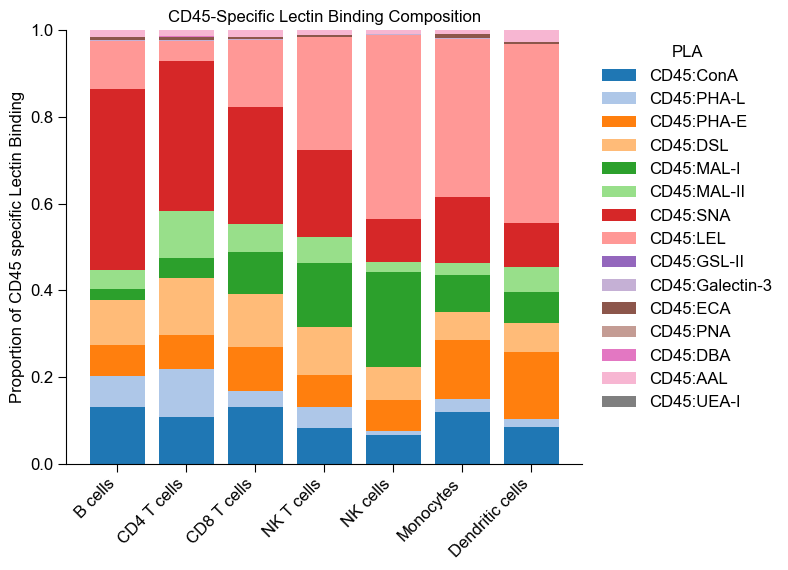

In [24]:
# --- Step 1: Extract lectin names from CD45:LECTIN columns ---
cd45_lectin_map = {col: col.split(':')[1] for col in d1_cd45_proportions.columns}

# --- Step 2: Sort columns based on lectin_order ---
sorted_columns = [col for lectin in d1_lectin_order
                  for col, l_name in cd45_lectin_map.items()
                  if l_name == lectin]

# --- Step 3: Reorder DataFrame ---
d1_cd45_plot = d1_cd45_proportions.loc[main_cell_type, sorted_columns]

# --- Bar positions ---
bar_positions = np.arange(len(main_cell_type))
stack_data = [d1_cd45_plot[col].values for col in d1_cd45_plot.columns]

# --- Plotting ---
fig, ax = plt.subplots(figsize=(len(main_cell_type) * 0.6 + 4, 6))
bottom = np.zeros(len(main_cell_type))
colors = plt.cm.tab20.colors  # 20 distinct colors

for i, (lectin_pair, values) in enumerate(zip(d1_cd45_plot.columns, stack_data)):
    ax.bar(bar_positions, values, bottom=bottom, label=lectin_pair, color=colors[i % len(colors)])
    bottom += values

# --- Formatting ---
ax.set_xticks(bar_positions)
ax.set_xticklabels(main_cell_type, rotation=45, ha='right')
ax.set_ylabel("Proportion of CD45 specific Lectin Binding")
ax.set_ylim(0, 1.0)
ax.set_title("CD45-Specific Lectin Binding Composition")
ax.legend(title="PLA", bbox_to_anchor=(1.01, 1), loc='upper left', frameon=False)

fig.tight_layout(pad=1.5)
sns.despine()

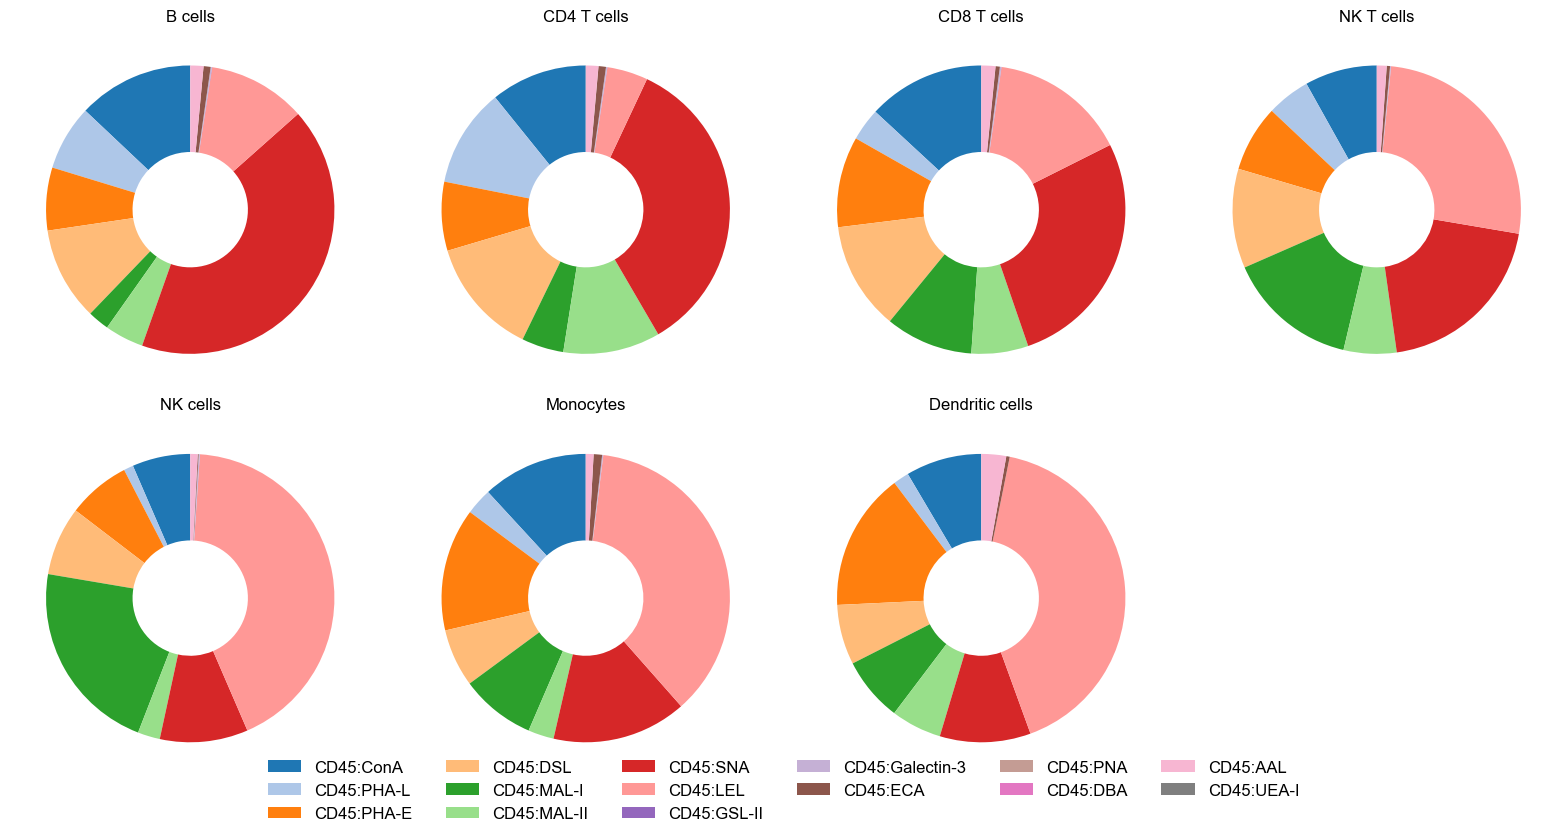

In [26]:
num_cells = len(main_cell_type)
num_lectins = len(d1_cd45_plot.columns)

# Colors
colors = plt.cm.tab20.colors

# Layout: 2 rows, compute cols needed
nrows = 2
ncols = math.ceil(num_cells / nrows)

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 4), subplot_kw=dict(aspect="equal"))
axes = axes.flatten()

for ax, cell_type in zip(axes, main_cell_type):
    values = d1_cd45_plot.loc[cell_type].values
    labels = d1_cd45_plot.columns

    wedges = ax.pie(
        values,
        labels=None,   # no percentage labels
        startangle=90,
        colors=[colors[i % len(colors)] for i in range(num_lectins)],
        wedgeprops=dict(width=0.6)
    )
    ax.set_title(cell_type)

# Hide any unused subplots
for ax in axes[num_cells:]:
    ax.axis('off')

# Legend at bottom, two rows
fig.legend(
    labels=d1_cd45_plot.columns,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.05),
    ncol=min(num_lectins, 6),
    frameon=False
)

#fig.suptitle("CD45-Specific Lectin Binding Composition", y=1.05, fontsize=16)
fig.tight_layout()

sns.despine(left=True, bottom=True)

fig.savefig(save_dir + 'ldt_CD45_profile.svg', format = 'svg', bbox_inches='tight', pad_inches=0)

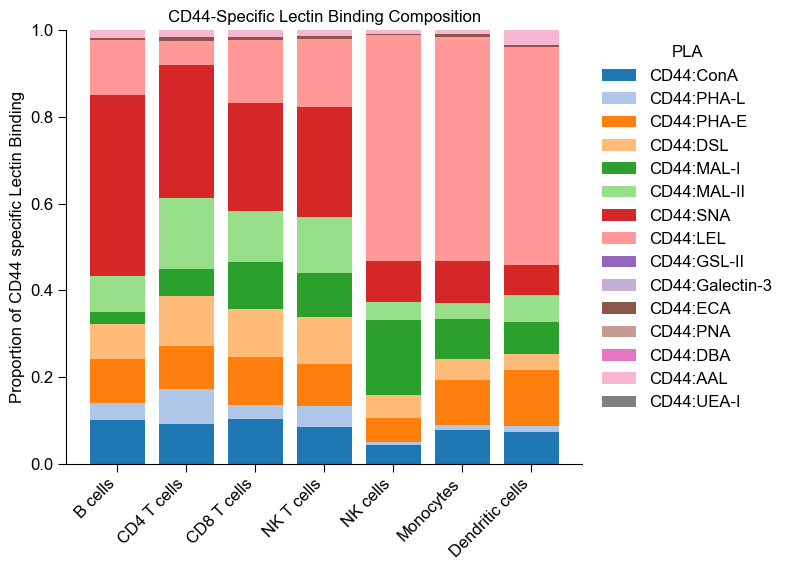

In [20]:
# --- Step 1: Extract lectin names from CD44:LECTIN columns ---
cd44_lectin_map = {col: col.split(':')[1] for col in d1_cd44_proportions.columns}

# --- Step 2: Sort columns based on predefined lectin order ---
sorted_cd44_columns = [col for lectin in d1_lectin_order
                       for col, l_name in cd44_lectin_map.items()
                       if l_name == lectin]

# --- Step 3: Reorder DataFrame ---
d1_cd44_plot = d1_cd44_proportions.loc[main_cell_type, sorted_cd44_columns]

# --- Bar positions ---
bar_positions = np.arange(len(main_cell_type))
stack_data = [d1_cd44_plot[col].values for col in d1_cd44_plot.columns]

# --- Plotting ---
fig, ax = plt.subplots(figsize=(len(main_cell_type) * 0.6 + 4, 6))
bottom = np.zeros(len(main_cell_type))
colors = plt.cm.tab20.colors  # or use lectin_color_map if you want glycan-specific colors

for i, (lectin_pair, values) in enumerate(zip(d1_cd44_plot.columns, stack_data)):
    lectin_name = lectin_pair.split(":")[1]
    color = lectin_color_map.get(lectin_name, colors[i % len(colors)])  # use defined glycan-color map
    ax.bar(bar_positions, values, bottom=bottom, label=lectin_pair, color=color)
    bottom += values

# --- Formatting ---
ax.set_xticks(bar_positions)
ax.set_xticklabels(main_cell_type, rotation=45, ha='right')
ax.set_ylabel("Proportion of CD44 specific Lectin Binding")
ax.set_ylim(0, 1.0)
ax.set_title("CD44-Specific Lectin Binding Composition")
ax.legend(title="PLA", bbox_to_anchor=(1.01, 1), loc='upper left', frameon=False)

fig.tight_layout(pad=1.5)
sns.despine()

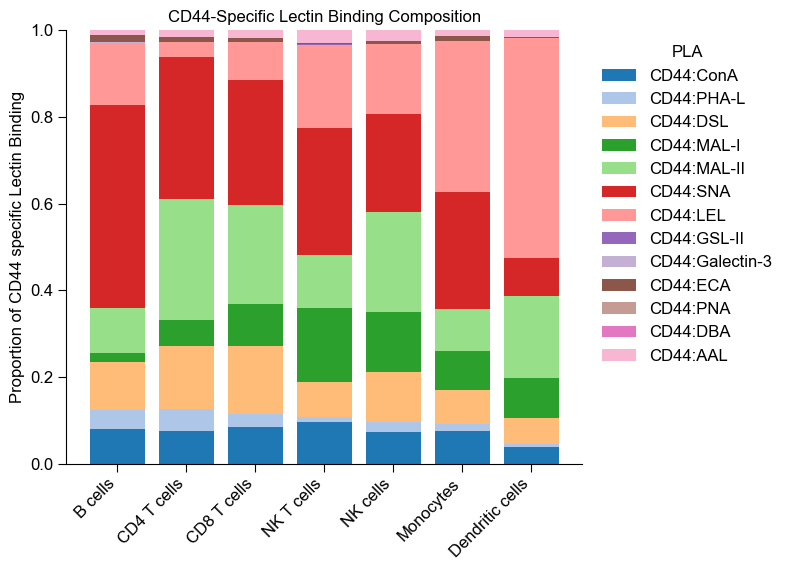

In [21]:
# --- Step 1: Extract lectin names from CD44:LECTIN columns ---
cd44_lectin_map_d2 = {col: col.split(':')[1] for col in d2_cd44_proportions.columns}

# --- Step 2: Match global lectin order but only keep those in Donor 2 ---
sorted_cd44_columns_d2 = [
    col for lectin in d2_lectin_order
    for col, l_name in cd44_lectin_map_d2.items()
    if l_name == lectin
]

# --- Step 3: Reorder DataFrame ---
d2_cd44_plot = d2_cd44_proportions.loc[main_cell_type, sorted_cd44_columns_d2]

# --- Bar positions ---
bar_positions = np.arange(len(main_cell_type))
stack_data = [d2_cd44_plot[col].values for col in d2_cd44_plot.columns]

# --- Plotting ---
fig, ax = plt.subplots(figsize=(len(main_cell_type) * 0.6 + 4, 6))
bottom = np.zeros(len(main_cell_type))
colors = plt.cm.tab20.colors  # fallback if not in lectin_color_map

for i, (lectin_pair, values) in enumerate(zip(d2_cd44_plot.columns, stack_data)):
    lectin_name = lectin_pair.split(":")[1]
    color = lectin_color_map.get(lectin_name, colors[i % len(colors)])
    ax.bar(bar_positions, values, bottom=bottom, label=lectin_pair, color=color)
    bottom += values

# --- Formatting ---
ax.set_xticks(bar_positions)
ax.set_xticklabels(main_cell_type, rotation=45, ha='right')
ax.set_ylabel("Proportion of CD44 specific Lectin Binding")
ax.set_ylim(0, 1.0)
ax.set_title("CD44-Specific Lectin Binding Composition")
ax.legend(title="PLA", bbox_to_anchor=(1.01, 1), loc='upper left', frameon=False)

fig.tight_layout(pad=1.5)
sns.despine()


In [67]:
ctrl_pla = PC.plaObject(d1_target)
ctrl_pla.calculateProteinCount()
my_protein = [
    "CD45", "CD47", "CD48", "CD44", "CD2", "CD3", "CD4", "CD8", "CD5", "CD7",
    "CD27", "CD45RA", "CD45RO", "CD62L", "CCR5", "CCR7", "CD127", "CD25", "CD28",
    "CD137", "CD154", "CD150", "CD38", "PD1", "TIM-3", "LAG-3", "CTLA-4",
    "CD19", "CD20", "CD56", "CD16", "CD14", "CD11b", "CD11c", "HLADR", "CXCR3",
    "CXCR4", "CD11a", "CD49e", "CD29", "ICAM-1", "CD81", "CD147"]
my_lectin = ["PHA-L", "PHA-E", "DSL", "ConA", "PNA", "MAL-I", "MAL-II", "SNA", "DBA",
    "ECA", "AAL", "LEL", "GSL-II", "Galectin-3", "UEA-I"]
ctrl_protein = ctrl_pla.protein_count.loc[my_protein,:]
ctrl_lectin = ctrl_pla.protein_count.loc[my_lectin,:]
#CLR normalization
clr_ctrl_protein = ctrl_protein.apply(clr_function, axis=0)
clr_ctrl_lectin = ctrl_lectin.apply(clr_function, axis=0)

In [71]:
#extract #NKCD56+CD16+ vs NKCD56+CD16-
nk_5616_indices = donor1_annotation[donor1_annotation["manual_annotation"] == "NK cells_CD56+CD16+"].index
nk_56_indices = donor1_annotation[donor1_annotation["manual_annotation"] == "NK cells_CD56+CD16-"].index
nk_5616_protein = clr_ctrl_protein[nk_5616_indices].T
nk_56_protein = clr_ctrl_protein[nk_56_indices].T
nk_5616_lectin = clr_ctrl_lectin[nk_5616_indices].T
nk_56_lectin = clr_ctrl_lectin[nk_56_indices].T

In [72]:
#protein expression difference
from scipy.stats import ranksums

# Ensure columns (proteins) are the same and aligned
common_proteins = nk_5616_protein.columns.intersection(nk_56_protein.columns)
results = []

for marker in common_proteins:
    values_5616 = nk_5616_protein[marker].dropna()
    values_56 = nk_56_protein[marker].dropna()

    stat, pval = ranksums(values_5616, values_56)
    logfc = values_5616.mean() - values_56.mean()

    results.append({
        'marker': marker,
        'logFC': logfc,
        'pval': pval
    })

de_df = pd.DataFrame(results)

In [74]:
from statsmodels.stats.multitest import multipletests

de_df['pval_adj'] = multipletests(de_df['pval'], method='fdr_bh')[1]
de_df = de_df.sort_values('pval_adj')

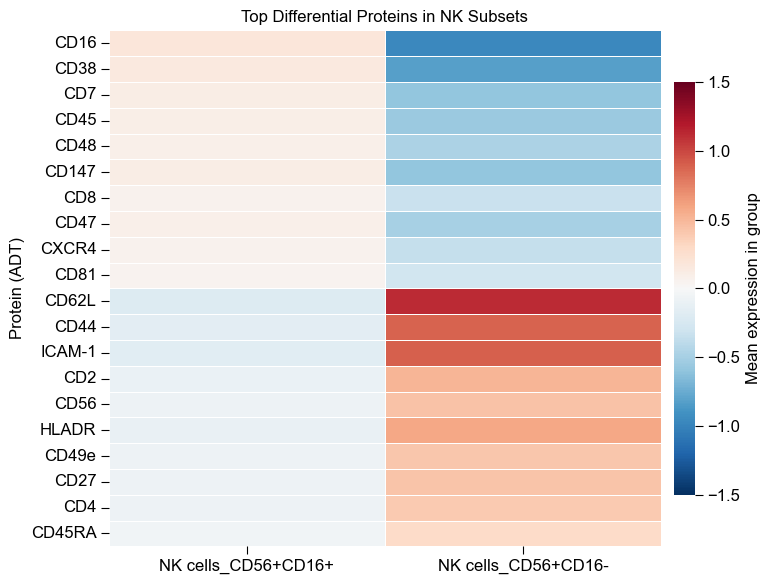

In [116]:
# --- Step 1: Select top markers ---
cd5616_high_top = de_df[(de_df['logFC'] > 0) & (de_df['pval_adj'] < 0.05)] \
                    .sort_values('logFC', ascending=False)['marker'].head(10).tolist()

cd56_high_top = de_df[(de_df['logFC'] < 0) & (de_df['pval_adj'] < 0.05)] \
                    .sort_values('logFC')['marker'].head(10).tolist()

# --- Step 2: Label and combine ---
nk_5616_protein['group'] = 'NK cells_CD56+CD16+'
nk_56_protein['group'] = 'NK cells_CD56+CD16-'

combined = pd.concat([
    nk_5616_protein[cd5616_high_top + cd56_high_top + ['group']],
    nk_56_protein[cd5616_high_top + cd56_high_top + ['group']]
])

# --- Step 3: Apply z-score (standardize each marker) ---
marker_cols = combined.columns.drop('group')
zscored = combined[marker_cols].apply(zscore)  # z-score across all cells
zscored['group'] = combined['group']

# Optional: clip for visual clarity like Scanpy
zscored[marker_cols] = zscored[marker_cols].clip(-10, 10)

# --- Step 4: Compute group-wise averages ---
group_means = zscored.groupby('group').mean().T

# --- Step 5: Plot heatmap ---
plt.figure(figsize=(8, 6))
sns.heatmap(
    group_means,
    cmap='RdBu_r',
    center=0,
    linewidths=0.4,
    cbar_kws={
        'label': 'Mean expression in group',
        'shrink': 0.8,
        'orientation': 'vertical',
        'pad': 0.02
    },
    vmin=-1.5,
    vmax=1.5
)
plt.title('Top Differential Proteins in NK Subsets')
plt.xlabel('')
plt.ylabel('Protein (ADT)')
plt.tight_layout()
plt.show()

In [84]:
# Shared lectins
common_lectins = nk_5616_lectin.columns.intersection(nk_56_lectin.columns)

# Run DE for each lectin
results = []
for lectin in common_lectins:
    vals_5616 = nk_5616_lectin[lectin].dropna()
    vals_56 = nk_56_lectin[lectin].dropna()
    
    stat, pval = ranksums(vals_5616, vals_56)
    logfc = vals_5616.mean() - vals_56.mean()
    
    results.append({'lectin': lectin, 'logFC': logfc, 'pval': pval})

# Format results
lectin_de_df = pd.DataFrame(results)
lectin_de_df['pval_adj'] = multipletests(lectin_de_df['pval'], method='fdr_bh')[1]
lectin_de_df = lectin_de_df.sort_values('pval_adj')

# Top lectins higher in CD56+CD16+
lectin_high_5616 = lectin_de_df[(lectin_de_df['logFC'] > 0) & (lectin_de_df['pval_adj'] < 0.05)] \
                      .sort_values('logFC', ascending=False)['lectin'].head(10).tolist()

# Top lectins higher in CD56+CD16-
lectin_high_56 = lectin_de_df[(lectin_de_df['logFC'] < 0) & (lectin_de_df['pval_adj'] < 0.05)] \
                    .sort_values('logFC')['lectin'].head(10).tolist()

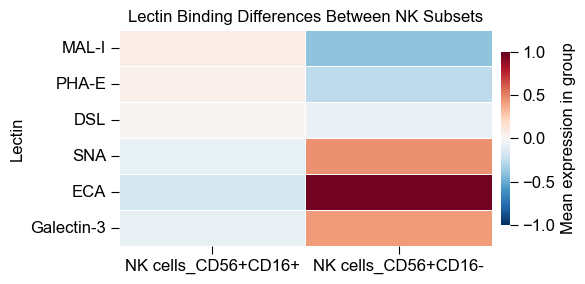

In [115]:
# Label and combine
nk_5616_lectin['group'] = 'NK cells_CD56+CD16+'
nk_56_lectin['group'] = 'NK cells_CD56+CD16-'

combined_lectin = pd.concat([
    nk_5616_lectin[lectin_high_5616 + lectin_high_56 + ['group']],
    nk_56_lectin[lectin_high_5616 + lectin_high_56 + ['group']]
])

# --- Step 3: Apply z-score (standardize each marker) ---
marker_cols = combined_lectin.columns.drop('group')
zscored = combined_lectin[marker_cols].apply(zscore)  # z-score across all cells
zscored['group'] = combined_lectin['group']

# Optional: clip for visual clarity like Scanpy
zscored[marker_cols] = zscored[marker_cols].clip(-10, 10)

group_means = zscored.groupby('group').mean().T


plt.figure(figsize=(6, 3))
sns.heatmap(
    group_means,
    cmap='RdBu_r',
    center=0,
    linewidths=0.4,
    cbar_kws={
        'label': 'Mean expression in group',
        'shrink': 0.8,                   # make bar shorter
        'orientation': 'vertical',       # vertical is default
        'pad': 0.02                      # space between heatmap and bar
    },
    vmin=-1, vmax=1                # fix color scale range
)
plt.title('Lectin Binding Differences Between NK Subsets')
plt.xlabel('')
plt.ylabel('Lectin')
plt.tight_layout()
plt.show()

In [ ]:
#for PLA differential expression of NK subsets, please see Protein_lectin